In [1]:
import math
import datetime
import re

#from z3 import Int, IntVector, Bool, Optimize, Implies, And, Or, If, sat

from olsq.solve import OLSQ
from olsq.input import input_qasm
from olsq.output import output_qasm
from olsq.device import qcdevice
import pkgutil

from ortools.linear_solver import pywraplp
from ortools.sat.python import cp_model


import qiskit
import qiskit.qasm2
from qiskit import QuantumCircuit,transpile
from qiskit_aer import AerSimulator

from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [2]:
def print_histo(counts):    
# Convert the dictionary keys to integers for sorting
    # Get all possible binary values
    all_binary_values = ['{:04b}'.format(i) for i in range(2**len(list(counts.keys())[0]))]

    # Create a dictionary with zero counts for all possible binary values
    full_counts = {binary_value: counts.get(binary_value, 0) for binary_value in all_binary_values}

    # Sort keys and values based on keys (binary representation)
    sorted_counts = {k: full_counts[k] for k in sorted(full_counts.keys())}

    # Plot the histogram
    plt.bar(sorted_counts.keys(), sorted_counts.values())

    # Set labels and title
    plt.xlabel('Measured binary strings')
    plt.ylabel('Counts')
    plt.title('Measurments')

    # Diagonally rotate x-axis labels
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.show()

In [3]:
def compare_distribuitions(counts1,counts2):

    counts_diff={}
    mean_diff=0
    tot_count=0
    KL=0

    for string in counts1.keys():
        counts_diff[string]=None

    for string in counts1.keys():
        tot_count+=counts1[string]

    for string in counts1.keys():
        counts_diff[string]=(abs(counts1[string]/tot_count-counts2[string]/tot_count))

    for string in counts1.keys():
        mean_diff+=counts_diff[string]

    for string in counts1.keys():
        KL+=(counts1[string]/tot_count)*math.log((counts1[string]/tot_count)/(counts2[string]/tot_count))


    return mean_diff/2, max(counts_diff.values()),KL

In [4]:
def swap_to_cnot(qasm):


    # Regular expression to find the 'swaps q[x], q[y];' pattern
    pattern = r'swap q\[(\d+)\], q\[(\d+)\];'
    
    # Replacement function
    def replacement(match):
        x = match.group(1)
        y = match.group(2)
        return f'cx q[{x}], q[{y}]; cx q[{y}], q[{x}]; cx q[{x}], q[{y}];'
    
    # Perform the substitution
    result = re.sub(pattern, replacement, qasm)
    return result


In [5]:
def collision_extracting(list_gate_qubits):
    """Extract collision relations between the gates,
    If two gates g_1 and g_2 both acts on a qubit (at different time),
    we say that g_1 and g_2 collide on that qubit, which means that
    (1,2) will be in collision list.

    Args:
        list_gate_qubits: a list of gates in OLSQ IR
    
    Returns:
        list_collision: a list of collisions between the gates
    """

    list_collision = list()
    # We sweep through all the gates.  For each gate, we sweep through all the
    # gates after it, if they both act on some qubit, append them in the list.
    for g in range(len(list_gate_qubits)):
        for gg in range(g + 1, len(list_gate_qubits)):
            
            if list_gate_qubits[g][0] == list_gate_qubits[gg][0]:
                    list_collision.append((g, gg))
                
            if len(list_gate_qubits[gg]) == 2:
                if list_gate_qubits[g][0] == list_gate_qubits[gg][1]:
                    list_collision.append((g, gg))
            
            if len(list_gate_qubits[g]) == 2:
                if list_gate_qubits[g][1] == list_gate_qubits[gg][0]:
                    list_collision.append((g, gg))
                if len(list_gate_qubits[gg]) == 2:
                    if list_gate_qubits[g][1] == list_gate_qubits[gg][1]:
                        list_collision.append((g, gg))
    
    return tuple(list_collision)

def dependency_extracting(list_gate_qubits, count_program_qubit: int):
    """Extract dependency relations between the gates.
    If two gates g_1 and g_2 both acts on a qubit *and there is no gate
    between g_1 and g_2 that act on this qubit*, we then say that
    g2 depends on g1, which means that (1,2) will be in dependency list.

    Args:
        list_gate_qubits: a list of gates in OLSQ IR
        count_program_qubit: the number of logical/program qubit
    
    Returns:
        list_dependency: a list of dependency between the gates
    """

    list_dependency = []
    list_last_gate = [-1 for i in range(count_program_qubit)]
    # list_last_gate records the latest gate that acts on each qubit.
    # When we sweep through all the gates, this list is updated and the
    # dependencies induced by the update is noted.
    for i, qubits in enumerate(list_gate_qubits):
        
        if list_last_gate[qubits[0]] >= 0:
            list_dependency.append((list_last_gate[qubits[0]], i))
        list_last_gate[qubits[0]] = i

        if len(qubits) == 2:
            if list_last_gate[qubits[1]] >= 0:
                list_dependency.append((list_last_gate[qubits[1]], i))
            list_last_gate[qubits[1]] = i

    return tuple(list_dependency)


class ILP2(OLSQ):
    def __init__(self, objective_name, mode):
        """Set the objective of OLSQ, and whether it is transition-based

        Args:
            objective_name: can be "depth", "swap", or "fidelity"
            mode: can be "normal" or "transition" (TB-OLSQ in the paper)       
        """
        
        if objective_name == "depth":
            self.objective_name = objective_name
        elif objective_name == "swap":
            self.objective_name = objective_name
        elif objective_name == "fidelity":
            self.objective_name = objective_name
        else:
            raise ValueError("Invalid Objective Name")

    

        # These values should be updated in setdevice(...)
        self.device = None
        self.count_physical_qubit = 0
        self.list_qubit_edge = []
        self.swap_duration = 0

        # These values should be updated in setprogram(...)
        self.list_gate_qubits = []
        self.count_program_qubit = 0
        self.list_gate_name = []
        
        # bound_depth is a hyperparameter
        self.bound_depth = 0

        self.inpput_dependency = False
        self.list_gate_dependency = []

    def setdevice(self, device: qcdevice):
        """Pass in parameters from the given device.  If in TB mode,
           swap_duration is set to 1 without modifying the device.

        Args:
            device: a qcdevice object for OLSQ
        """
     
        self.device = device
        self.count_physical_qubit = device.count_physical_qubit
        self.list_qubit_edge = device.list_qubit_edge
        self.swap_duration = device.swap_duration
        

          

    def setprogram(self, program, input_mode: str = None):
        """Translate input program to OLSQ IR, and set initial depth
        An example of the intermediate representation is shown below.
        It contains three things: 1) the number of qubit in the program,
        2) a list of tuples representing qubit(s) acted on by a gate,
        the tuple has one index if it is a single-qubit gate,
        two indices if it is a two-qubit gate, and 3) a list of
        type/name of each gate, which is not important to OLSQ,
        and only needed when generating output.
        If in TB mode, initial depth=1; in normal mode, we perform ASAP
        scheduling without consideration of SWAP to calculate depth.

        Args:
            program: a qasm string, or a list of the three things in IR.
            input_mode: (optional) can be "IR" if the input has ben
                translated to OLSQ IR; can be "benchmark" to use one of
                the benchmarks.  Default mode assumes qasm input.

        Example:
            For the following circuit
                q_0: ───────────────────■───
                                        │  
                q_1: ───────■───────────┼───
                     ┌───┐┌─┴─┐┌─────┐┌─┴─┐
                q_2: ┤ H ├┤ X ├┤ TDG ├┤ X ├─
                     └───┘└───┘└─────┘└───┘ 
            count_program_qubit = 3
            gates = ((2,), (1,2), (2,), (0,1))
            gate_spec = ("h", "cx", "tdg", "cx")
        """
        
        if input_mode == "IR":
            self.count_program_qubit = program[0]
            self.list_gate_qubits = program[1]
            self.list_gate_name = program[2]
        elif input_mode == "benchmark":
            f = pkgutil.get_data(__name__, "benchmarks/" + program + ".qasm")
            program = input_qasm(f.decode("utf-8"))
            self.count_program_qubit = program[0]
            self.list_gate_qubits = program[1]
            self.list_gate_name = program[2]
        else:
            program = input_qasm(program)
            self.count_program_qubit = program[0]
            self.list_gate_qubits = program[1]
            self.list_gate_name = program[2]

        # calculate the initial depth
        
        push_forward_depth = [0 for i in range(self.count_program_qubit)]
        # for qubits in self.list_gate_qubits:
        #     if len(qubits) == 1:
        #         push_forward_depth[qubits[0]] += 1
        #     else:
        #         tmp_depth = push_forward_depth[qubits[0]]

        #         if tmp_depth < push_forward_depth[qubits[1]]:
        #             tmp_depth = push_forward_depth[qubits[1]]
        #             push_forward_depth[qubits[1]] = tmp_depth + 1

        #         push_forward_depth[qubits[0]] = tmp_depth + 1
        # self.bound_depth = max(push_forward_depth)


        for qubits in self.list_gate_qubits:
            if len(qubits) == 1:
                push_forward_depth[qubits[0]] += 1
            else:
                tmp_depth = max(push_forward_depth[qubits[0]],push_forward_depth[qubits[1]])

                push_forward_depth[qubits[0]]=tmp_depth+1
                push_forward_depth[qubits[1]]=tmp_depth+1
                
        self.bound_depth = max(push_forward_depth)

    def setdependency(self, dependency: list):
        """Specify dependency (non-commutation)

        Args:
            dependency: a list of gate index pairs
        
        Example:
            For the following circuit
                q_0: ───────────────────■───
                                        │  
                q_1: ───────■───────────┼───
                     ┌───┐┌─┴─┐┌─────┐┌─┴─┐
                q_2: ┤ H ├┤ X ├┤ TDG ├┤ X ├─
                     └───┘└───┘└─────┘└───┘ 
                gate   0    1     2     3
            dependency = [(0,1), (1,2), (2,3)]

            However, for this QAOA subcircuit (ZZ gates may have phase
            parameters, but we neglect them for simplicity here)
                         ┌──┐ ┌──┐
                q_0: ────┤ZZ├─┤  ├─
                     ┌──┐└┬─┘ │ZZ│  
                q_1: ┤  ├─┼───┤  ├─
                     │ZZ│┌┴─┐ └──┘
                q_2: ┤  ├┤ZZ├──────
                     └──┘└──┘ 
                gate   0   1   2
            dependency = []    # since ZZ gates are commutable
        """
        self.list_gate_dependency = dependency
        self.inpput_dependency = True

    def solve(self, output_mode: str = None, output_file_name: str = None):
        """Formulate an SMT, pass it to z3 solver, and output results.
        CORE OF OLSQ, EDIT WITH CARE.

        Args:
            output_mode: "IR" or left to default.
            output_file_name: a file to store the IR output or qasm.
        
        Returns:
            a list of results depending on output_mode
            "IR": 
            | list_scheduled_gate_name: name/type of each gate
            | list_scheduled_gate_qubits: qubit(s) each gate acts on
            | final_mapping: logical qubit |-> physical qubit in the end 
            | objective_value: depth/#swap/fidelity depending on setting
            None:
              a qasm string
              final_mapping
              objective_value
        """

        objective_name = self.objective_name
        device = self.device
        list_gate_qubits = self.list_gate_qubits
        count_program_qubit = self.count_program_qubit
        list_gate_name = self.list_gate_name
        count_physical_qubit = self.count_physical_qubit
        list_qubit_edge = self.list_qubit_edge
        swap_duration = self.swap_duration
        bound_depth = self.bound_depth
        

         
      
        # pre-processing

        count_qubit_edge = len(list_qubit_edge)
        count_gate = len(list_gate_qubits)
        if self.objective_name == "fidelity":
            list_logfidelity_single = [
                int(1000 * math.log(device.list_fidelity_single[n]))
                for n in range(count_physical_qubit)]
            list_logfidelity_two = [
                int(1000 * math.log(device.list_fidelity_two[k]))
                for k in range(count_qubit_edge)]
            list_logfidelity_measure = [
                int(1000 * math.log(device.list_fidelity_measure[n]))
                for n in range(count_physical_qubit)]
        list_gate_two = list()
        list_gate_single = list()
        for l in range(count_gate):
            if len(list_gate_qubits[l]) == 1:
                list_gate_single.append(l)
            else:
                list_gate_two.append(l)

        # list_adjacency_qubit takes in a physical qubit index _p_, and
        # returns the list of indices of physical qubits adjacent to _p_
        list_adjacent_qubit = list()
        # list_span_edge takes in a physical qubit index _p_,
        # and returns the list of edges spanned from _p_
        list_span_edge = list()
        for n in range(count_physical_qubit):
            list_adjacent_qubit.append(list())
            list_span_edge.append(list())
        for k in range(count_qubit_edge):
            list_adjacent_qubit[list_qubit_edge[k][0]].append(list_qubit_edge[k][1])
            list_adjacent_qubit[list_qubit_edge[k][1]].append(list_qubit_edge[k][0])
            list_span_edge[list_qubit_edge[k][0]].append(k)
            list_span_edge[list_qubit_edge[k][1]].append(k)

        print('list_span_edge')
        print(list_span_edge)
        
        print('list_gate_qubits')
        print(list_gate_qubits)

        print('list_qubit_edge')
        print(list_qubit_edge)

        # if_overlap_edge takes in two edge indices _e_ and _e'_,
        # and returns whether or not they overlap
        if_overlap_edge = [[0] * count_qubit_edge
            for k in range(count_qubit_edge)]
        # list_over_lap_edge takes in an edge index _e_,
        # and returnsthe list of edges that overlap with _e_
        list_overlap_edge = list()
        # list_count_overlap_edge is the list of lengths of
        # overlap edge lists of all the _e_
        list_count_overlap_edge = list()
        for k in range(count_qubit_edge):
            list_overlap_edge.append(list())
        for k in range(count_qubit_edge):
            for kk in range(k + 1, count_qubit_edge):
                if (   (list_qubit_edge[k][0] == list_qubit_edge[kk][0]
                        or list_qubit_edge[k][0] == list_qubit_edge[kk][1])
                    or (list_qubit_edge[k][1] == list_qubit_edge[kk][0]
                        or list_qubit_edge[k][1] == list_qubit_edge[kk][1]) ):
                    list_overlap_edge[k].append(kk)
                    list_overlap_edge[kk].append(k)
                    if_overlap_edge[kk][k] = 1
                    if_overlap_edge[k][kk] = 1
        for k in range(count_qubit_edge):
            list_count_overlap_edge.append(len(list_overlap_edge[k]))

        if not self.inpput_dependency:
            list_gate_dependency = collision_extracting(list_gate_qubits)
        else:
            list_gate_dependency = self.list_gate_dependency

        # index function: takes two physical qubit indices _p_ and _p'_,
        # and returns the index of the edge between them if there is one
        map_edge_index = [[0] * count_physical_qubit] * count_physical_qubit
        for k in range(count_qubit_edge):
            map_edge_index[list_qubit_edge[k][0]][list_qubit_edge[k][1]] = k
            map_edge_index[list_qubit_edge[k][1]][list_qubit_edge[k][0]] = k

        not_solved = True
        start_time = datetime.datetime.now()
        
        
        model = cp_model.CpModel()
        solver = cp_model.CpSolver()
        solver.parameters.linearization_level = 2 # Use SCIP as the backend solver

        status = False
        start_time = datetime.datetime.now()


        while (status != cp_model.OPTIMAL and status != cp_model.FEASIBLE):

            
            print("Trying maximal depth = {}...".format(bound_depth))

            pi = [[model.new_int_var(0,count_physical_qubit,f'map_q{i}_t{j}') for j in range(bound_depth)]
                    for i in range(count_physical_qubit)]
            
            # time coordinate for gate l is time[l]
            time = [model.new_int_var(0,bound_depth,f'time_g{l}') for l in range(count_gate)]

            # space coordinate for gate l is space[l]
            space = [model.new_int_var(0,count_physical_qubit,f'space_g{l}') for l in range(count_gate)]

            # if at cycle t, a SWAP finishing on edge k, then sigma[k][t]=1
            sigma = [[model.new_bool_var('ifswap_e{i}_t{j}') for i in range(bound_depth)] for j in range(count_qubit_edge)]  

            #for depth optimization
            depth = model.new_int_var(0,bound_depth,'depth')

                # for swap optimization
            count_swap = model.new_int_var(0,bound_depth,'num_swap')

    #################################################################################################################################################


            dim1=max(count_gate,bound_depth,count_qubit_edge)
            dim2=max(count_gate,bound_depth,count_qubit_edge)

            
            #gurubi
            # Constraints
            for t in range(bound_depth):
                for m in range(count_program_qubit):
                    model.add(pi[m][t] >= 0)
                    model.add(pi[m][t] < count_physical_qubit)
                    for mm in range(m):
                        model.add(pi[m][t] != pi[mm][t])

            model.add(depth<=bound_depth)
            model.add(depth>=0)

                
            for d in list_gate_dependency:
                model.Add(time[d[0]] < time[d[1]])
         
            
            #to test initial placing
            # for t in range(bound_depth):
            #     for m in range(count_program_qubit):
            #         if t >0 :
            #             model.add(pi[m][t] == pi[m][t-1])
                        

            for l in range(count_gate):
                model.add(time[l] >= 0)
                model.add(time[l] < bound_depth)
                model.add(space[l] >= 0)
                model.add(space[l] < count_qubit_edge)


            condition00= [[model.new_bool_var(f'condition00[{l}][{t}]') for l in range(dim1)]for t in range(dim1)]
            condition01= [[model.new_bool_var(f'condition01[{l}][{t}]') for l in range(dim1)]for t in range(dim1)]            

            condition02= [[[model.new_bool_var(f'condition02[{l}][{k}][{t}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)]
            condition03= [[[model.new_bool_var(f'condition03[{l}][{k}][{t}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)]
            condition04= [[[model.new_bool_var(f'condition04[{l}][{k}][{t}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)]
            condition05= [[[model.new_bool_var(f'condition05[{l}][{k}][{t}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)]
            condition06= [[[model.new_bool_var(f'condition06[{l}][{k}][{t}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)]
            condition07= [[[model.new_bool_var(f'condition07[{l}][{k}][{t}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)]

            space_time= [[[model.new_bool_var(f'space_time[{l}][{k}][{t}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)]
            k0_l0_k1_l1= [[[model.new_bool_var(f'k0_l0_k1_l1[{l}][{k}][{t}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)]
            k0_l1_k1_l0= [[[model.new_bool_var(f'k0_l1_k1_l0[{l}][{k}][{t}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)]
            kl= [[[model.new_bool_var(f'kl[{l}][{k}][{t}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)]


            for l in range(count_gate):
                
                if l in list_gate_single:
                    for t in range(bound_depth):

                        model.add(time[l] == t).only_enforce_if(condition00[l][t])
                        model.add(time[l] != t).only_enforce_if(condition00[l][t].negated())

                        model.add(pi[list_gate_qubits[l][0]][t] == space[l]).only_enforce_if(condition01[l][t])
                        model.add(pi[list_gate_qubits[l][0]][t] != space[l]).only_enforce_if(condition01[l][t].negated())
                                
                        model.add_implication(condition00[l][t],condition01[l][t])

                elif l in list_gate_two:
                    for k in range(count_qubit_edge):
                        for t in range(bound_depth):


                            model.add(time[l] == t).only_enforce_if(condition06[l][k][t])
                            model.add(time[l] != t).only_enforce_if(condition06[l][k][t].negated())
                                
                            model.add(space[l] == k).only_enforce_if(condition07[l][k][t])
                            model.add(space[l] != k).only_enforce_if(condition07[l][k][t].negated())

                            model.add(list_qubit_edge[k][0] == pi[list_gate_qubits[l][0]][t]).only_enforce_if(condition02[l][k][t])
                            model.add(list_qubit_edge[k][0] != pi[list_gate_qubits[l][0]][t]).only_enforce_if(condition02[l][k][t].negated())

                            model.add(list_qubit_edge[k][1] == pi[list_gate_qubits[l][1]][t]).only_enforce_if(condition03[l][k][t])
                            model.add(list_qubit_edge[k][1] != pi[list_gate_qubits[l][1]][t]).only_enforce_if(condition03[l][k][t].negated())

                            model.add(list_qubit_edge[k][1] == pi[list_gate_qubits[l][0]][t]).only_enforce_if(condition04[l][k][t])
                            model.add(list_qubit_edge[k][1] != pi[list_gate_qubits[l][0]][t]).only_enforce_if(condition04[l][k][t].negated())
                            
                            model.add(list_qubit_edge[k][0] == pi[list_gate_qubits[l][1]][t]).only_enforce_if(condition05[l][k][t])
                            model.add(list_qubit_edge[k][0] != pi[list_gate_qubits[l][1]][t]).only_enforce_if(condition05[l][k][t].negated())
                            
                            #(6 and 7) ==> (2 and 3) or (4 and 5)
                            model.add_bool_and([condition06[l][k][t], condition07[l][k][t]]).OnlyEnforceIf(space_time[l][k][t])
                            model.add_bool_or([condition06[l][k][t].negated(), condition07[l][k][t].negated()]).only_enforce_if(space_time[l][k][t].negated())
                            
                            model.add_bool_and([condition02[l][k][t], condition03[l][k][t]]).only_enforce_if(k0_l0_k1_l1[l][k][t])
                            model.add_bool_or([condition02[l][k][t].negated(), condition03[l][k][t].negated()]).only_enforce_if(k0_l0_k1_l1[l][k][t].negated())
                            
                            model.add_bool_and([condition04[l][k][t], condition05[l][k][t]]).only_enforce_if(k0_l1_k1_l0[l][k][t])
                            model.add_bool_or([condition04[l][k][t].negated(), condition05[l][k][t].negated()]).only_enforce_if(k0_l1_k1_l0[l][k][t].negated())
                            
                                
                            model.add_bool_or([k0_l0_k1_l1[l][k][t], k0_l1_k1_l0[l][k][t]]).only_enforce_if(kl[l][k][t])
                            model.add_bool_and([k0_l0_k1_l1[l][k][t].negated(), k0_l1_k1_l0[l][k][t].negated()]).only_enforce_if(kl[l][k][t].negated())
                            
                            model.add_implication(space_time[l][k][t],kl[l][k][t])
                        
           
            #no swaps in the beginning otherwise do some random initial routing and then swaps before a configuration is needed
            for t in range(min(swap_duration - 1, bound_depth)):
            #for t in range(bound_depth):
                for k in range(count_qubit_edge):
                    model.Add(sigma[k][t] == 0)
                    

            condition42= [[[model.new_bool_var(f'condition42[{t}][{k}][{tt}]') for t in range(dim1)]for k in range(dim1)] for tt in range(dim1)]
            condition43= [[[model.new_bool_var(f'condition43[{t}][{k}][{tt}]') for t in range(dim1)]for k in range(dim1)]  for tt in range(dim1)]
            condition44= [[[[model.new_bool_var(f'condition44[{t}][{k}][{tt}][{kk}]') for t in range(dim1)]for k in range(dim1)]  for tt in range(dim1)] for kk in range(dim1)]
            condition45= [[[[model.new_bool_var(f'condition45[{t}][{k}][{tt}][{kk}]') for t in range(dim1)]for k in range(dim1)]  for tt in range(dim1)] for kk in range(dim1)]
            # after the beginning swaps cannot overlap with a swap on the same edge and on overlap edges
            for t in range(swap_duration - 1, bound_depth):
                for k in range(count_qubit_edge):
                    for tt in range(t - swap_duration + 1, t):
                        
                        model.add(sigma[k][tt]==False).only_enforce_if(condition42[t][k][tt])
                        model.add(sigma[k][tt]!=False).only_enforce_if(condition42[t][k][tt].negated())
                        
                        model.add(sigma[k][t]==True).only_enforce_if(condition43[t][k][tt])
                        model.add(sigma[k][t]!=True).only_enforce_if(condition43[t][k][tt].negated())

                        model.add_implication(condition43[t][k][tt], condition42[t][k][tt])

                    for tt in range(t - swap_duration + 1, t + 1):
                        for kk in list_overlap_edge[k]:
                            
                            model.add(sigma[k][t]==True).only_enforce_if(condition44[t][k][tt][kk])
                            model.add(sigma[k][t]!=True).only_enforce_if(condition44[t][k][tt][kk].negated())

                            model.add(sigma[kk][tt]==False).only_enforce_if(condition45[t][k][tt][kk])
                            model.add(sigma[kk][tt]!=False).only_enforce_if(condition45[t][k][tt][kk].negated())

                            model.add_implication(condition44[t][k][tt][kk], condition45[t][k][tt][kk])

        

            # condition18= [[[[model.new_bool_var(f'condition18[{l}][{k}][{t}][{tt}]') for l in range(dim2)] for k in range(dim2)] for t in range(dim2)] for tt in range(dim2)]
            # condition19= [[[[model.new_bool_var(f'condition19[{l}][{k}][{t}][{tt}]') for l in range(dim2)] for k in range(dim2)] for t in range(dim2)] for tt in range(dim2)]
            # condition20= [[[[model.new_bool_var(f'condition20[{l}][{k}][{t}][{tt}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)] for tt in range(dim2)]
            # condition21= [[[[model.new_bool_var(f'condition21[{l}][{k}][{t}][{tt}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)] for tt in range(dim2)]

            # condition22= [[[[[model.new_bool_var(f'condition22[{l}][{k}][{t}][{tt}][{kk}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)] for tt in range(dim2)] for kk in range(dim2)]
            # condition23= [[[[[model.new_bool_var(f'condition23[{l}][{k}][{t}][{tt}][{kk}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)] for tt in range(dim2)] for kk in range(dim2)]
            # condition24= [[[[[model.new_bool_var(f'condition24[{l}][{k}][{t}][{tt}][{kk}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)] for tt in range(dim2)] for kk in range(dim2)]
            # condition25= [[[[[model.new_bool_var(f'condition25[{l}][{k}][{t}][{tt}][{kk}]') for l in range(dim2)]for k in range(dim2)] for t in range(dim2)] for tt in range(dim2)] for kk in range(dim2)]

            # #if a double gate is happening on a edge a swap cannot occur on the same edge or on overalapping edges
            # for t in range(swap_duration - 1, bound_depth):
            #     for k in range(count_qubit_edge):
            #         for tt in range(t - swap_duration + 1, t + 1):
            #             for l in range(count_gate):

            #                 model.add(time[l] == tt).only_enforce_if(condition18[l][k][t][tt])
            #                 model.add(time[l] != tt).only_enforce_if(condition18[l][k][t][tt].negated())
            #                     #if double gate is between 2 qubits with an egde ==>sigma=0
            #                     #model.Add(space[l] == list_qubit_edge[k][0]).OnlyEnforceIf(condition19[l][k][t][tt])
                                
            #                 model.add(space[l] == k).only_enforce_if(condition19[l][k][t][tt])
            #                 model.add(space[l] != k).only_enforce_if(condition19[l][k][t][tt].negated())
                                
            #                 model.add(sigma[k][t] == 0).only_enforce_if(condition20[l][k][t][tt])
            #                 model.add(sigma[k][t] != 0).only_enforce_if(condition20[l][k][t][tt].negated())

            #                 # (18 && 19) ==> 20
            #                 model.add_bool_and([condition18[l][k][t][tt], condition19[l][k][t][tt]]).only_enforce_if(condition21[l][k][t][tt])
            #                 model.add_bool_or([condition18[l][k][t][tt].negated(), condition19[l][k][t][tt].negated()]).only_enforce_if(condition21[l][k][t][tt].negated())
                                
            #                 model.add_implication(condition21[l][k][t][tt],condition20[l][k][t][tt])
                    
            #                 for kk in list_overlap_edge[k]:

            #                     model.add(time[l] == tt).only_enforce_if(condition22[l][k][t][tt][kk])
            #                     model.add(time[l] != tt).only_enforce_if(condition22[l][k][t][tt][kk].negated())

            #                     model.add(space[l] == kk).only_enforce_if(condition23[l][k][t][tt][kk])
            #                     model.add(space[l] != kk).only_enforce_if(condition23[l][k][t][tt][kk].negated())

            #                     model.add(sigma[k][t] == 0).only_enforce_if(condition24[l][k][t][tt][kk])
            #                     model.add(sigma[k][t] != 0).only_enforce_if(condition24[l][k][t][tt][kk].negated())
                                    
            #                     # (22 && 23) ==> 24
            #                     model.add_bool_and([condition22[l][k][t][tt][kk], condition23[l][k][t][tt][kk]]).only_enforce_if(condition25[l][k][t][tt][kk])
            #                     model.add_bool_or([condition22[l][k][t][tt][kk].negated(), condition23[l][k][t][tt][kk].negated()]).only_enforce_if(condition25[l][k][t][tt][kk].negated())
                                
            #                     model.add_implication(condition25[l][k][t][tt][kk],condition24[l][k][t][tt][kk])

            dim3=max(count_physical_qubit,bound_depth,count_qubit_edge)

            condition26= [[[model.new_bool_var(f'condition26[{t}][{n}][{m}]') for t in range(dim3)] for n in range(dim3)] for m in range(dim3)]
            condition27= [[[model.new_bool_var(f'condition27[{t}][{n}][{m}]') for t in range(dim3)] for n in range(dim3)] for m in range(dim3)]
            condition28= [[[model.new_bool_var(f'condition28[{t}][{n}][{m}]') for t in range(dim3)] for n in range(dim3)] for m in range(dim3)]
            condition29= [[[model.new_bool_var(f'condition29[{t}][{n}][{m}]') for t in range(dim3)] for n in range(dim3)] for m in range(dim3)]
            sum_sigma= [[[model.new_int_var(0,count_qubit_edge,f'sum_sigma[{t}][{n}][{m}]') for t in range(dim3)] for n in range(dim3)] for m in range(dim3)]
            condition78= [[[model.new_bool_var(f'condition28[{t}][{n}][{m}]') for t in range(dim3)] for n in range(dim3)] for m in range(dim3)]
            condition79= [[[model.new_bool_var(f'condition29[{t}][{n}][{m}]') for t in range(dim3)] for n in range(dim3)] for m in range(dim3)]
            condition80= [[[model.new_bool_var(f'condition29[{t}][{n}][{m}]') for t in range(dim3)] for n in range(dim3)] for m in range(dim3)]



            # if there are no swaps the mapping is the same
            for t in range(bound_depth - 1):
                for n in range(count_physical_qubit):
                    for m in range(count_program_qubit):

                        # list_span_edge takes in a physical qubit index _p_,
                        # and returns the list of edges spanned from _p_

                        #sum sigma == 1 if qubit n at time t has a swap on one of his edges
                        sum_sigma[t][n][m] = sum(sigma[f][t] for f in list_span_edge[n])
                        #model.add(load[b] == sum(x[(i, b)] * items[i][0] for i in all_items))
                        # model.add(sum_sigma[t][n][m] ==1).OnlyEnforceIf(condition78[t][n][m])
                        # model.add(sum_sigma[t][n][m] ==0).OnlyEnforceIf(condition79[t][n][m])

                        # model.add_bool_or([condition78[t][n][m], condition79[t][n][m]]).OnlyEnforceIf(condition80[t][n][m])
                        # model.add_bool_and([condition78[t][n][m].negated(), condition79[t][n][m].negated()]).OnlyEnforceIf(condition80[t][n][m].negated())
                       
                        # model.add_implication(True,condition80[t][n][m])

                        #model.add(sum_sigma[t][n][m] <=1).OnlyEnforceIf(condition78[t][n][m])

                        model.add(sum_sigma[t][n][m] == 0).OnlyEnforceIf(condition26[t][n][m])
                        model.add(sum_sigma[t][n][m] != 0).OnlyEnforceIf(condition26[t][n][m].negated())

                        model.add(pi[m][t] == n).OnlyEnforceIf(condition27[t][n][m])
                        model.add(pi[m][t] != n).OnlyEnforceIf(condition27[t][n][m].negated())

                        model.add(pi[m][t+1] == n).OnlyEnforceIf(condition28[t][n][m])
                        model.add(pi[m][t+1] != n).OnlyEnforceIf(condition28[t][n][m].negated())

                        model.add_bool_and([condition26[t][n][m], condition27[t][n][m]]).OnlyEnforceIf(condition29[t][n][m])
                        model.add_bool_or([condition26[t][n][m].negated(), condition27[t][n][m].negated()]).OnlyEnforceIf(condition29[t][n][m].negated())
                       
                        model.add_implication(condition29[t][n][m],condition28[t][n][m])

            

            condition30= [[[model.new_bool_var(f'condition30[{t}][{k}][{m}]') for t in range(dim3)] for k in range(dim3)] for m in range(dim3)]
            condition31= [[[model.new_bool_var(f'condition31[{t}][{k}][{m}]') for t in range(dim3)] for k in range(dim3)] for m in range(dim3)]
            condition32= [[[model.new_bool_var(f'condition32[{t}][{k}][{m}]') for t in range(dim3)] for k in range(dim3)] for m in range(dim3)]
            condition33= [[[model.new_bool_var(f'condition33[{t}][{k}][{m}]') for t in range(dim3)] for k in range(dim3)] for m in range(dim3)]

            condition34= [[[model.new_bool_var(f'condition34[{t}][{k}][{m}]') for t in range(dim3)] for k in range(dim3)] for m in range(dim3)]
            condition35= [[[model.new_bool_var(f'condition35[{t}][{k}][{m}]') for t in range(dim3)] for k in range(dim3)] for m in range(dim3)]
            condition36= [[[model.new_bool_var(f'condition36[{t}][{k}][{m}]') for t in range(dim3)] for k in range(dim3)] for m in range(dim3)]


            #if there is a swap on edge k the mapping change (the 2 qubit of edge k are swapped)
            for t in range(bound_depth -1 ):
                for k in range(count_qubit_edge):
                    for m in range(count_program_qubit):

                        model.add(sigma[k][t] == 1).OnlyEnforceIf(condition30[t][k][m])
                        model.add(sigma[k][t] != 1).OnlyEnforceIf(condition30[t][k][m].negated())

                        model.add(pi[m][t] == list_qubit_edge[k][0]).OnlyEnforceIf(condition31[t][k][m])
                        model.add(pi[m][t] != list_qubit_edge[k][0]).OnlyEnforceIf(condition31[t][k][m].negated())

                        model.add(pi[m][t+1] == list_qubit_edge[k][1]).OnlyEnforceIf(condition32[t][k][m])
                        model.add(pi[m][t+1] != list_qubit_edge[k][1]).OnlyEnforceIf(condition32[t][k][m].negated())

                        #(30 && 31) ==> 32
                        model.add_bool_and([condition30[t][k][m], condition31[t][k][m]]).OnlyEnforceIf(condition33[t][k][m])
                        model.add_bool_or([condition30[t][k][m].negated(), condition31[t][k][m].negated()]).OnlyEnforceIf(condition33[t][k][m].negated())
                       
                        model.add_implication(condition33[t][k][m],condition32[t][k][m])

                        #################################################################

                        model.add(pi[m][t] == list_qubit_edge[k][1]).OnlyEnforceIf(condition34[t][k][m])
                        model.add(pi[m][t] != list_qubit_edge[k][1]).OnlyEnforceIf(condition34[t][k][m].negated())

                        model.add(pi[m][t+1] == list_qubit_edge[k][0]).OnlyEnforceIf(condition35[t][k][m])
                        model.add(pi[m][t+1] != list_qubit_edge[k][0]).OnlyEnforceIf(condition35[t][k][m].negated())

                        #(30 && 34) ==> 35
                        model.add_bool_and([condition30[t][k][m], condition34[t][k][m]]).OnlyEnforceIf(condition36[t][k][m])
                        model.add_bool_or([condition30[t][k][m].negated(), condition34[t][k][m].negated()]).OnlyEnforceIf(condition36[t][k][m].negated())
                        
                        model.add_implication(condition36[t][k][m],condition35[t][k][m])

            # Count swap constraints
            model.add(count_swap == sum(sigma[k][t] for k in range(count_qubit_edge) for t in range(bound_depth)))

            # Depth optimization constraints
            for l in range(count_gate):
                model.add(depth >= time[l] + 1)

            # Objective function
            model.minimize(count_swap)
            

            # Create a solver and solve the model
            solver = cp_model.CpSolver()
                

            status = solver.solve(model)

            if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
                print(f'Solution found:')
                for k in range(count_qubit_edge):
                    for t in range(bound_depth):
                        print(f'sigma[{k}][{t}] = {solver.Value(sigma[k][t])}')
                for m in range(count_program_qubit):
                    for t in range(bound_depth):
                        print(f'pi[{m}][{t}] = {solver.Value(pi[m][t])}')
                for l in range(count_gate):
                    print(f'time[{l}] = {solver.Value(time[l])}')
                    print(f'space[{l}] = {solver.Value(space[l])}')
                print(f'depth = {solver.Value(depth)}')
                print(f'count_swap = {solver.Value(count_swap)}')
            else:
                #bound_depth = int(1.3 * bound_depth)
                bound_depth+=1
                print('No solution found')

##################################################################################################

        compilation_time=datetime.datetime.now() - start_time

        print(f"Compilation time = {compilation_time}.")
        

        #print(model.ExportModelAsLpFormat(False).replace('\\', '').replace(',_', ','), sep='\n')

        model.export_to_file('model.txt')

        # post-processing
        result_time = []
        #result_depth = solver.Value(depth)
        #result_depth = solver.Value(bound_depth)
        result_depth=bound_depth
        
        for l in range(count_gate):
            result_time.append(solver.Value(time[l]))
        
        list_result_swap = []
        for k in range(count_qubit_edge):
            for t in range(result_depth):
                if solver.Value(sigma[k][t]):
                    list_result_swap.append((k, t))
                    #print(f"SWAP on physical edge ({list_qubit_edge[k][0]}, {list_qubit_edge[k][1]}) at time {t}")
        
        for l in range(count_gate):
            if len(list_gate_qubits[l]) == 1:
                qq = list_gate_qubits[l][0]
                tt = result_time[l]
                #print(f"Gate {l}: {list_gate_name[l]} {qq} on qubit {solver.Value(pi[qq][tt])} at time {tt}")
            else:
                qq = list_gate_qubits[l][0]
                qqq = list_gate_qubits[l][1]
                tt = result_time[l]
                #print(f"Gate {l}: {list_gate_name[l]} {qq}, {qqq} on qubits {solver.Value(pi[qq][tt])} and {solver.Value(pi[qqq][tt])} at time {tt}")
        
        objective_value = solver.Value(depth)
        #print(f"result circuit depth = {objective_value}.")
        
        list_scheduled_gate_qubits = [[] for _ in range(result_depth)]
        list_scheduled_gate_name = [[] for _ in range(result_depth)]
        
        for l in range(count_gate):
            t = result_time[l]
            list_scheduled_gate_name[t].append(list_gate_name[l])
            
            if l in list_gate_single:
                q = solver.Value(space[l])
                list_scheduled_gate_qubits[t].append((q,))
            elif l in list_gate_two:
                q0, q1 = list_gate_qubits[l]
                tmp_t = t
                q0 = solver.Value(pi[q0][tmp_t])
                q1 = solver.Value(pi[q1][tmp_t])
                list_scheduled_gate_qubits[t].append((q0, q1))
            else:
                raise ValueError("Expect single-qubit or two-qubit gate.")
        
        final_mapping = []
        for m in range(count_program_qubit):
            tmp_depth = result_depth - 1
            final_mapping.append(solver.Value(pi[m][tmp_depth]))

        for (k, t) in list_result_swap:
            q0 = list_qubit_edge[k][0]
            q1 = list_qubit_edge[k][1]
            if self.swap_duration == 1:
                list_scheduled_gate_qubits[t].append((q0, q1))
                list_scheduled_gate_name[t].append("swap")
            elif self.swap_duration == 3:
                list_scheduled_gate_qubits[t].append((q0, q1))
                list_scheduled_gate_name[t].append("CX")
                list_scheduled_gate_qubits[t - 1].append((q1, q0))
                list_scheduled_gate_name[t - 1].append("CX")
                list_scheduled_gate_qubits[t - 2].append((q0, q1))
                list_scheduled_gate_name[t - 2].append("CX")
            else:
                raise ValueError("Expect SWAP duration one, or three")
            
###################################################################################################

        qasm=output_qasm(device, result_depth, list_scheduled_gate_name,
                            list_scheduled_gate_qubits, final_mapping,
                            True, output_file_name)


        return (result_depth,
                    list_scheduled_gate_name,
                    list_scheduled_gate_qubits,
                    final_mapping,
                    objective_value,
                    qasm,
                    compilation_time)

In [6]:
qasm_test='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[4];
creg c[4];

cx q[0], q[1];
cx q[0], q[2];
cx q[0], q[3];


cx q[0], q[1];
cx q[0], q[2];
cx q[0], q[3];


// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];

'''

qasm_input_QAOA_3='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[3];
creg c[3];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];

rz(0) q[0];
cx q[0], q[1];
rz(1) q[1];

cx q[0], q[2];
rz(2) q[2];

rz(1.3) q[0];
cx q[0], q[1];

cx q[0], q[2];
rz(1.3) q[1];
rz(1.3) q[2];

rz(1.3) q[0];


// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
'''

qasm_input_QAOA_4='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[4];
creg c[4];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];

rz(0) q[0];
cx q[0], q[1];
rz(1) q[1];

cx q[0], q[2];
rz(2) q[2];

cx q[0], q[3];
rz(3) q[3];

rz(1.3) q[0];
cx q[0], q[1];

cx q[0], q[2];

rz(1.3) q[1];
rz(1.3) q[2];

cx q[0], q[3];
rz(1.3) q[3];
rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
'''

qasm_input_QAOA_5='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[5];
creg c[5];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];

rz(0) q[0];
cx q[0], q[1];
rz(1) q[1];

cx q[0], q[2];
rz(2) q[2];

cx q[0], q[3];
rz(3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

rz(1.3) q[0];
cx q[0], q[1];

cx q[0], q[2];

rz(1.3) q[1];
rz(1.3) q[2];

cx q[0], q[3];
rz(1.3) q[3];

cx q[0], q[4];
rz(1.3) q[4];
rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
'''

qasm_input_QAOA_6='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[6];
creg c[6];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];

rz(0) q[0];

cx q[0], q[1];
rz(1) q[1];

cx q[0], q[2];
rz(2) q[2];

cx q[0], q[3];
rz(3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

rz(1.3) q[0];

cx q[0], q[1];
rz(1.3) q[1];

cx q[0], q[2];
rz(1.3) q[2];

cx q[0], q[3];
rz(1.3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
'''

qasm_input_QAOA_7='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[7];
creg c[7];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];

rz(0) q[0];

cx q[0], q[1];
rz(1) q[1];

cx q[0], q[2];
rz(2) q[2];

cx q[0], q[3];
rz(3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[6];
rz(1.3) q[6];


rz(1.3) q[0];

cx q[0], q[1];
rz(1.3) q[1];

cx q[0], q[2];
rz(1.3) q[2];

cx q[0], q[3];
rz(1.3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[6];
rz(1.3) q[6];


rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
measure q[6] -> c[6];
'''

qasm_input_QAOA_8='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[8];
creg c[8];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];
h q[7];

rz(0) q[0];

cx q[0], q[1];
rz(1) q[1];

cx q[0], q[2];
rz(2) q[2];

cx q[0], q[3];
rz(3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[6];
rz(1.3) q[6];

cx q[0], q[7];
rz(1.3) q[7];


rz(1.3) q[0];

cx q[0], q[1];
rz(1.3) q[1];

cx q[0], q[2];
rz(1.3) q[2];

cx q[0], q[3];
rz(1.3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[6];
rz(1.3) q[6];

cx q[0], q[7];
rz(1.3) q[7];

rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
measure q[6] -> c[6];
measure q[7] -> c[7];
'''

qasm_input_QAOA_9='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[9];
creg c[9];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];
h q[7];
h q[8];

rz(0) q[0];

cx q[0], q[1];
rz(1) q[1];

cx q[0], q[2];
rz(2) q[2];

cx q[0], q[3];
rz(3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[6];
rz(1.3) q[6];

cx q[0], q[7];
rz(1.3) q[7];

cx q[0], q[8];
rz(1.3) q[8];


rz(1.3) q[0];

cx q[0], q[1];
rz(1.3) q[1];

cx q[0], q[2];
rz(1.3) q[2];

cx q[0], q[3];
rz(1.3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[6];
rz(1.3) q[6];

cx q[0], q[7];
rz(1.3) q[7];

cx q[0], q[8];
rz(1.3) q[8];


rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
measure q[6] -> c[6];
measure q[7] -> c[7];
measure q[8] -> c[8];
'''


qasm_input_random_3='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[3];
creg c[3];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];

rz(0) q[0];

cx q[0], q[2];
rz(1) q[1];

cx q[1], q[2];
rz(2) q[2];


rz(1.3) q[0];

cx q[0], q[1];
rz(1.3) q[1];

cx q[0], q[2];
rz(1.3) q[2];



// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
'''
qasm_input_random_5='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[5];
creg c[5];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];

rz(0) q[0];
cx q[1], q[3];
rz(1) q[1];

cx q[2], q[3];
rz(2) q[2];

cx q[1], q[4];
rz(3) q[3];

cx q[2], q[4];
rz(1.3) q[4];

rz(1.3) q[0];
cx q[0], q[2];

cx q[2], q[3];

rz(1.3) q[1];
rz(1.3) q[2];

cx q[0], q[3];
rz(1.3) q[3];

cx q[0], q[4];
rz(1.3) q[4];
rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
'''
qasm_input_random_7='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[7];
creg c[7];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];

rz(0) q[0];

cx q[0], q[2];
rz(1) q[1];

cx q[2], q[3];
rz(2) q[2];

cx q[1], q[5];
rz(3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[3], q[5];
rz(1.3) q[5];

cx q[2], q[3];
rz(1.3) q[6];


rz(1.3) q[0];

cx q[0], q[2];
rz(1) q[1];

cx q[2], q[3];
rz(2) q[2];

cx q[1], q[5];
rz(3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[3], q[5];
rz(1.3) q[5];

cx q[2], q[3];
rz(1.3) q[6];

rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
measure q[6] -> c[6];
'''
qasm_input_random_9='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[9];
creg c[9];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];
h q[7];
h q[8];

rz(0) q[0];

cx q[1], q[3];
rz(1) q[1];

cx q[4], q[8];
rz(2) q[2];

cx q[1], q[5];
rz(3) q[3];

cx q[2], q[6];
rz(1.3) q[4];

cx q[4], q[7];
rz(1.3) q[5];

cx q[2], q[3];
rz(1.3) q[6];

cx q[1], q[5];
rz(1.3) q[7];

cx q[6], q[8];
rz(1.3) q[8];


rz(1.3) q[0];

cx q[4], q[8];
rz(1.3) q[1];

cx q[3], q[7];
rz(1.3) q[2];

cx q[1], q[6];
rz(1.3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[1], q[4];
rz(1.3) q[5];

cx q[5], q[7];
rz(1.3) q[6];

cx q[4], q[8];
rz(1.3) q[7];

cx q[3], q[5];
rz(1.3) q[8];


rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
measure q[6] -> c[6];
measure q[7] -> c[7];
measure q[8] -> c[8];
'''
qasm_input_random_15='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[15];
creg c[15];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];
h q[7];
h q[8];
h q[9];
h q[10];
h q[11];
h q[12];
h q[13];
h q[14];

rz(0) q[0];

cx q[5], q[10];
rz(1) q[1];

cx q[2], q[13];
rz(2) q[2];


cx q[2], q[4];
rz(3) q[3];

cx q[4], q[13];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[14];
rz(1.3) q[6];

cx q[2], q[7];
rz(1.3) q[7];

cx q[1], q[5];
rz(1.3) q[8];

cx q[4], q[12];
rz(1.3) q[9];

cx q[10], q[11];
rz(1.3) q[10];

cx q[0], q[4];
rz(1.3) q[11];

cx q[3], q[12];
rz(1.3) q[12];

cx q[7], q[9];
rz(1.3) q[13];

cx q[8], q[13];
rz(1.3) q[14];


rz(1.3) q[0];

cx q[5], q[10];
rz(1) q[1];

cx q[2], q[13];
rz(2) q[2];

cx q[2], q[13];
rz(3) q[3];

cx q[4], q[13];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[0], q[14];
rz(1.3) q[6];

cx q[2], q[7];
rz(1.3) q[7];

cx q[1], q[5];
rz(1.3) q[8];

cx q[4], q[12];
rz(1.3) q[9];

cx q[10], q[11];
rz(1.3) q[10];

cx q[0], q[4];
rz(1.3) q[11];

cx q[3], q[7];
rz(1.3) q[12];

cx q[7], q[9];
rz(1.3) q[13];

cx q[3], q[8];
rz(1.3) q[14];

rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
measure q[6] -> c[6];
measure q[7] -> c[7];
measure q[8] -> c[8];
measure q[9] -> c[9];
measure q[10] -> c[10];
measure q[11] -> c[11];
measure q[12] -> c[12];
measure q[13] -> c[13];
measure q[14] -> c[14];
'''

qasm_input_random1_3='''

OPENQASM 2.0;
include "qelib1.inc";

qreg q[3];
creg c[3];

// Initial state preparation: Apply Hadamard gates to all qubits
x q[0];
x q[1];
x q[2];

h q[0];
cx q[0], q[2];
rz(1) q[1];

cx q[2], q[1];
rz(2) q[2];

rz(1.3) q[0];
cx q[0], q[2];

cx q[0], q[1];
x q[1];
x q[2];

x q[0];


// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
'''
qasm_input_random1_5='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[5];
creg c[5];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];

rz(0) q[0];
cx q[1], q[2];
rz(1) q[1];

cx q[2], q[3];
rz(2) q[2];

cx q[1], q[4];
rz(3) q[3];

cx q[2], q[4];
rz(1.3) q[4];

rz(1.3) q[0];
cx q[0], q[2];

cx q[1], q[3];

rz(1.3) q[1];
rz(1.3) q[2];

cx q[0], q[2];
rz(1.3) q[3];

cx q[1], q[4];
rz(1.3) q[4];
rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
'''
qasm_input_random1_7='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[7];
creg c[7];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];

rz(0) q[0];

cx q[0], q[2];
rz(1) q[1];

cx q[1], q[3];
rz(2) q[2];

cx q[1], q[4];
rz(3) q[3];

cx q[3], q[6];
rz(1.3) q[4];

cx q[3], q[5];
rz(1.3) q[5];

cx q[0], q[3];
rz(1.3) q[6];


rz(1.3) q[0];

cx q[0], q[4];
rz(1) q[1];

cx q[3], q[6];
rz(2) q[2];

cx q[2], q[6];
rz(3) q[3];

cx q[0], q[4];
rz(1.3) q[4];

cx q[2], q[5];
rz(1.3) q[5];

cx q[3], q[6];
rz(1.3) q[6];

rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
measure q[6] -> c[6];
'''
qasm_input_random1_9='''
OPENQASM 2.0;
include "qelib1.inc";

qreg q[9];
creg c[9];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];
h q[7];
h q[8];

rz(0) q[0];

cx q[1], q[4];
rz(1) q[1];

cx q[4], q[7];
rz(2) q[2];

cx q[3], q[5];
rz(3) q[3];

cx q[4], q[8];
rz(1.3) q[4];

cx q[5], q[6];
rz(1.3) q[5];

cx q[7], q[8];
rz(1.3) q[6];

cx q[5], q[6];
rz(1.3) q[7];

cx q[3], q[8];
rz(1.3) q[8];


rz(1.3) q[0];

cx q[4], q[5];
rz(1.3) q[1];

cx q[2], q[6];
rz(1.3) q[2];

cx q[1], q[4];
rz(1.3) q[3];

cx q[0], q[3];
rz(1.3) q[4];

cx q[1], q[2];
rz(1.3) q[5];

cx q[5], q[7];
rz(1.3) q[6];

cx q[3], q[4];
rz(1.3) q[7];

cx q[2], q[5];
rz(1.3) q[8];


rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
measure q[6] -> c[6];
measure q[7] -> c[7];
measure q[8] -> c[8];
'''
qasm_input_random1_15='''

OPENQASM 2.0;
include "qelib1.inc";

qreg q[15];
creg c[15];

// Initial state preparation: Apply Hadamard gates to all qubits
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];
h q[7];
h q[8];
h q[9];
h q[10];
h q[11];
h q[12];
h q[13];
h q[14];

rz(0) q[0];

cx q[3], q[10];
rz(1) q[1];

cx q[4], q[13];
rz(2) q[2];


cx q[6], q[14];
rz(3) q[3];

cx q[5], q[13];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[3], q[11];
rz(1.3) q[6];

cx q[2], q[7];
rz(1.3) q[7];

cx q[1], q[5];
rz(1.3) q[8];

cx q[10], q[12];
rz(1.3) q[9];

cx q[3], q[11];
rz(1.3) q[10];

cx q[0], q[4];
rz(1.3) q[11];

cx q[11], q[12];
rz(1.3) q[12];

cx q[7], q[9];
rz(1.3) q[13];

cx q[1], q[13];
rz(1.3) q[14];


rz(1.3) q[0];

cx q[3], q[10];
rz(1) q[1];

cx q[4], q[13];
rz(2) q[2];


cx q[6], q[14];
rz(3) q[3];

cx q[5], q[13];
rz(1.3) q[4];

cx q[0], q[5];
rz(1.3) q[5];

cx q[3], q[11];
rz(1.3) q[6];

cx q[2], q[7];
rz(1.3) q[7];

cx q[4], q[5];
rz(1.3) q[8];

cx q[10], q[12];
rz(1.3) q[9];

cx q[3], q[11];
rz(1.3) q[10];

cx q[0], q[4];
rz(1.3) q[11];

cx q[0], q[12];
rz(1.3) q[12];

cx q[7], q[9];
rz(1.3) q[13];

cx q[1], q[13];
rz(1.3) q[14];

rz(1.3) q[0];

// Measurement
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
measure q[6] -> c[6];
measure q[7] -> c[7];
measure q[8] -> c[8];
measure q[9] -> c[9];
measure q[10] -> c[10];
measure q[11] -> c[11];
measure q[12] -> c[12];
measure q[13] -> c[13];
measure q[14] -> c[14];
'''





      ┌───┐┌───────┐                                                          »
 q_0: ┤ H ├┤ Rz(0) ├────────────────────────────────────────────────────■─────»
      ├───┤├───────┤                                                    │     »
 q_1: ┤ H ├┤ Rz(1) ├────────────────────────────────────────────────────┼─────»
      ├───┤├───────┤                                                    │     »
 q_2: ┤ H ├┤ Rz(2) ├─────────────────────────────────────────■──────────┼─────»
      ├───┤└───────┘┌───────┐                                │          │     »
 q_3: ┤ H ├────■────┤ Rz(3) ├────────────────────────────────┼──────────┼─────»
      ├───┤    │    └───────┘┌─────────┐                     │          │     »
 q_4: ┤ H ├────┼────────■────┤ Rz(1.3) ├─────────────────────┼──────────┼─────»
      ├───┤    │        │    └─────────┘                     │        ┌─┴─┐   »
 q_5: ┤ H ├────┼────────┼────────────────────────────■───────┼────────┤ X ├───»
      ├───┤    │        │               

KeyboardInterrupt: 

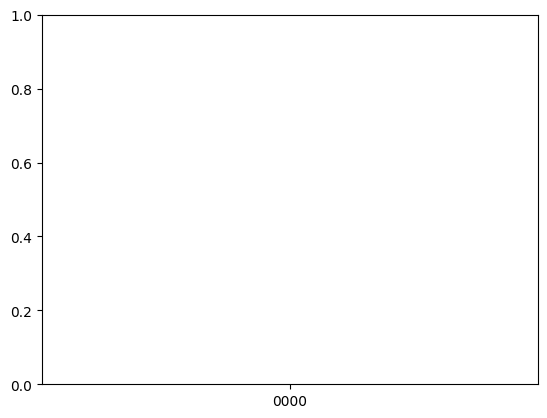

In [8]:
solver = ILP2("depth", "normal")


bowtie_connections = [(0,1),(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),(7,8),(8,9),(9,10),(10,11),(11,12),(12,13),(13,14)]
bowtie_dev = qcdevice("bowtie", nqubits=15, connection=bowtie_connections, 
                  swap_duration=1)

solver.setdevice(bowtie_dev)


circuit = QuantumCircuit()
circuit = circuit.from_qasm_str(str(qasm_input_random1_15))
#print(qasm_input1)
print(circuit)

simulator = AerSimulator()

# Run and get counts
result = simulator.run(circuit,shots=1).result()
counts = result.get_counts(circuit)
#plot_histogram(counts)
#plt.savefig('histogram.png')

#print_histo(counts)

solver.setprogram(qasm_input_random1_15)


result_depth, list_scheduled_gate_name, list_scheduled_gate_qubits,\
final_mapping, objective_value, qasm_output,compilation_time = solver.solve()

qasm_output_cnot=swap_to_cnot(qasm_output)

#print(qasm)
circuit1 = QuantumCircuit()
circuit1 = circuit1.from_qasm_str(str(qasm_output_cnot))
print(circuit1)

result1 = simulator.run(circuit1,shots=1).result()
counts1 = result1.get_counts(circuit1)
print(counts1)
print_histo(counts1)



print('depth before')
print(circuit.depth())

print('depth after')
print(circuit1.depth())

print('compilation_time')
print(compilation_time)

print('total variation distance: Mean_diff/2, max_diff, KL Divergence')
print(compare_distribuitions(counts,counts1))